In [23]:
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
import os
import csv
import argparse
import torch
import numpy as np

from models.gru import SentimentGRU_A
from models.transformer import SentimentTransformerEncoder_C

from dataset import SentimentAnalysisDataset, LABEL_MAP
from test import run_test

from sklearn.metrics import accuracy_score, confusion_matrix

RESULTS_DIR = 'results'

MODELS = {
    'a': SentimentGRU_A,
    'b': None,
    'c': SentimentTransformerEncoder_C
}

data_path = 'data'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
model_a_results = pd.read_csv('results/A_06_05_13_26.csv')
model_a_results.head()

,epoch,train_loss,test_accuracy,test_loss
0,0,1.091527,0.374199,5264.969281
1,1,1.090217,0.374199,5273.727972
2,2,1.089319,0.415340,5249.073193
3,3,1.084758,0.374406,5254.393646
4,4,1.057179,0.459582,5081.258321


In [4]:
model_b_results = pd.read_csv('results/C_06_05_13_25.csv')
model_b_results.head()

,epoch,train_loss,test_accuracy,test_loss
0,0,1.092011,0.357246,5288.116433
1,1,1.089173,0.357246,5282.380267
2,2,1.089461,0.344428,5267.107588
3,3,1.086512,0.369237,5278.806653
4,4,1.053851,0.472814,5135.366665


### Loss comparison

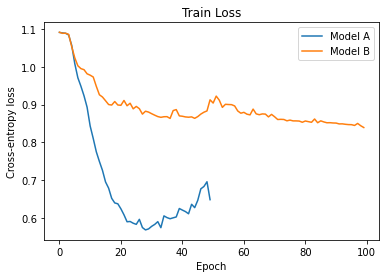

In [11]:
plt.figure()
plt.title('Train Loss')
plt.plot(model_a_results.train_loss)
plt.plot(model_b_results.train_loss)
plt.xlabel('Epoch')
plt.ylabel('Cross-entropy loss')
plt.legend(['Model A', 'Model B'])
plt.show()

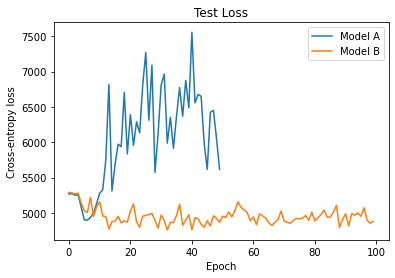

In [9]:
plt.figure()
plt.title('Test Loss')
plt.plot(model_a_results.test_loss)
plt.plot(model_b_results.test_loss)
plt.xlabel('Epoch')
plt.ylabel('Cross-entropy loss')
plt.legend(['Model A', 'Model B'])
plt.show()

### Accuracy

In [32]:
print('Model A best accuracy:', model_a_results.test_accuracy.max())
print('Model B best accuracy:', model_b_results.test_accuracy.max())

Model A best accuracy: 0.5230514781889601
Model B best accuracy: 0.5654331197022948


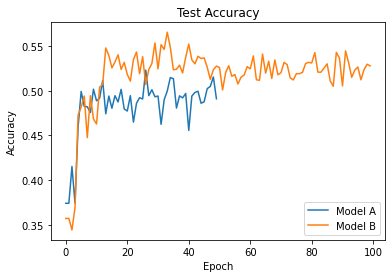

In [12]:
plt.figure()
plt.title('Test Accuracy')
plt.plot(model_a_results.test_accuracy)
plt.plot(model_b_results.test_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Model A', 'Model B'])
plt.show()

### Confusion matrix

In [17]:
model_a = SentimentGRU_A(100)
model_a.load_state_dict(torch.load('models/A_06_05_13_26.state'))
model_a.to(device)
model_a.eval()

SentimentGRU_A(
  (gru): GRU(100, 128, num_layers=4, batch_first=True, dropout=0.1, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=64, out_features=64, bias=True)
    (10): ReLU()
    (11): Linear(in_features=64, out_features=3, bias=True)
  )
)

In [18]:
model_b = SentimentTransformerEncoder_C(100)
model_b.load_state_dict(torch.load('models/C_06_05_13_25.state'))
model_b.to(device)
model_b.eval()

SentimentTransformerEncoder_C(
  (tranformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=2048, bias=True)
        (dropou

In [20]:
train_dataset = SentimentAnalysisDataset(os.path.join(data_path, 'trainEmotions.csv'))

-> Loading word embeddings


In [19]:
test_dataset = SentimentAnalysisDataset(os.path.join(data_path, 'testEmotions.csv'))

-> Loading word embeddings


In [26]:
def calc_conf_mat(model, dataset, device):
    y_true = []
    y_predict = []

    model.eval()
    with torch.no_grad():
        for tokens, label in dataset:
            
            tokens = tokens.to(device).float()
            label = label.to(device)

            y_true.append(int(label.argmax()))

            if tokens.squeeze().dim() == 0 or len(tokens.squeeze()) == 0:
                # Predict neutral if no token after processing 
                # e.g., only stopwords in the original text
                y_predict.append(int(LABEL_MAP['neutral']))
                continue

            # Forward pass
            output = model(tokens)
            if output.dim() != 1 or output.shape[0] != 3:
                print(output.shape, tokens.shape, label.shape)
            assert output.dim() == 1 and output.shape[0] == 3
            y_predict.append(int(torch.softmax(output, dim=0).argmax()))

    y_true = np.array(y_true)
    y_predict = np.array(y_predict)

    return confusion_matrix(y_true, y_predict)

In [27]:
# Model A Train set confusion matrix
cm_a_train = calc_conf_mat(model_a, train_dataset, device)
cm_a_train

array([[3904, 1341,  185],
       [ 582, 4165,  435],
       [  65,  915, 2912]])

In [28]:
# Model A Train set confusion matrix
cm_a_test = calc_conf_mat(model_a, test_dataset, device)
cm_a_test

array([[ 503,  745,  563],
       [ 114, 1048,  566],
       [  86,  388,  824]])

In [29]:
# Model A test set confusion matrix
cm_b_train = calc_conf_mat(model_b, train_dataset, device)
cm_b_train

array([[3105, 2102,  223],
       [ 803, 4104,  275],
       [ 371, 1666, 1855]])

In [30]:
# Model A Train set confusion matrix
cm_b_test = calc_conf_mat(model_b, test_dataset, device)
cm_b_test

array([[ 662,  761,  388],
       [ 158, 1215,  355],
       [  97,  525,  676]])